In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import gammapy
print("gammapy:", gammapy.__version__)

gammapy: 0.18.2


In [2]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from regions import CircleSkyRegion
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    PointSpatialModel,
    FoVBackgroundModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, RingBackgroundMaker, FoVBackgroundMaker
from gammapy.modeling import Fit
from gammapy.maps import Map
from scipy.stats import norm
from gammapy.data import Observation
from gammapy.datasets import MapDataset, MapDatasetOnOff
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator

In [3]:
import scipy.stats as stats
import math
import statistics
import os

In [4]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [5]:
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

Invalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [6]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 200.0 * u.hr
l = 0.1
pointing = SkyCoord(141.409467, 40.566962, unit="deg", frame="galactic")

In [7]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.0, 10), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(141.409467, 40.566962),
    binsz=0.02,
    width=(3, 3),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy_true", interp="log"
)

empty = MapDataset.create(geom, name="dataset-simu")

In [8]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = PointSpatialModel(
    lon_0="141.409467 deg", lat_0="40.566962 deg", frame="galactic"
)
#spectral_model = PowerLawSpectralModel(
#    index=2.22, amplitude="1.289e-12 cm-2 s-1 TeV-1", reference="1 TeV"
#)

spectral_model = ExpCutoffPowerLawSpectralModel(
    index=2.495, amplitude="2.72e-13 cm-2 s-1 TeV-1", reference="1 TeV", lambda_=l * u.Unit("TeV-1"), alpha = 1
)


model_simu = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu, bkg_model])
print(models)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   2.495              
    amplitude               :   2.72e-13  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.100  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   : 141.409  deg         
    lat_0                   :  40.567  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [9]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=3.5 * u.deg)
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)
dataset.models = models
dataset.fake(random_state=42)
print(dataset)

Observation

	obs id            : 0 
 	tstart            : 51544.00
	tstop             : 51552.33
	duration          : 720000.00 s
	pointing (icrs)   : 149.0 deg, 69.7 deg

	deadtime fraction : 0.0%

MapDataset
----------

  Name                            : dataset-simu 

  Total counts                    : 5433144 
  Total background counts         : 5421739.65
  Total excess counts             : 11404.35

  Predicted counts                : 5433401.68
  Predicted background counts     : 5421739.65
  Predicted excess counts         : 11662.03

  Exposure min                    : 1.02e+11 m2 s
  Exposure max                    : 2.61e+12 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -34303517.72

  Number of models                : 2 
  Number of parameters            : 10
  Number of free parameters       : 6

  Component 0: SkyModel
  
    Name               

In [10]:
dataset1 = dataset.copy()
dataset1.models = bkg_model
print(dataset1)

MapDataset
----------

  Name                            : tPDWFizg 

  Total counts                    : 5433144 
  Total background counts         : 5421739.65
  Total excess counts             : 11404.35

  Predicted counts                : 5421739.65
  Predicted background counts     : 5421739.65
  Predicted excess counts         : nan

  Exposure min                    : 1.02e+11 m2 s
  Exposure max                    : 2.61e+12 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -34294984.52

  Number of models                : 0 
  Number of parameters            : 0
  Number of free parameters       : 0

  


In [11]:
# Using a convolution radius of 0.04 degrees
estimator = ExcessMapEstimator(0.04 * u.deg, selection_optional=[])
lima_maps = estimator.run(dataset1)

In [12]:
significance_map = lima_maps["sqrt_ts"]
excess_map = lima_maps["excess"]

(<Figure size 720x720 with 4 Axes>,
 <matplotlib.colorbar.Colorbar at 0x7f7578128ac8>)

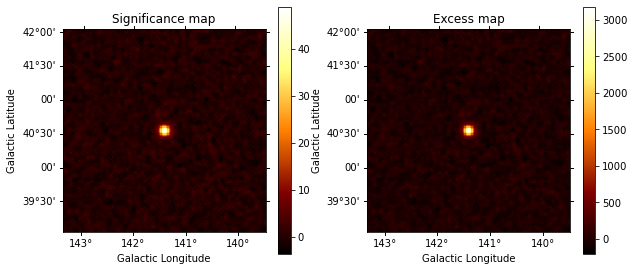

In [13]:
# We can plot the excess and significance maps
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True)

In [14]:
geom_image = geom.to_image().to_cube([energy_reco.squash()])
regions = CircleSkyRegion(center=pointing, radius=0.2 * u.deg)
exclusion_mask = Map.from_geom(geom_image)
exclusion_mask.data = geom_image.region_mask([regions], inside=False)
maker_fov = FoVBackgroundMaker(method="fit", exclusion_mask=exclusion_mask)

In [15]:
dataset1 = maker_fov.run(dataset1)
print(dataset1)

MapDataset
----------

  Name                            : tPDWFizg 

  Total counts                    : 5433144 
  Total background counts         : 5421739.65
  Total excess counts             : 11404.35

  Predicted counts                : 5421921.19
  Predicted background counts     : 5421921.19
  Predicted excess counts         : 0.00

  Exposure min                    : 1.02e+11 m2 s
  Exposure max                    : 2.61e+12 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -34294985.27

  Number of models                : 1 
  Number of parameters            : 3
  Number of free parameters       : 1

  Component 0: FoVBackgroundModel
  
    Name                      : tPDWFizg-bkg
    Datasets names            : ['tPDWFizg']
    Spectral model type       : PowerLawNormSpectralModel
    Parameters:
      norm                    :   1.000              
    

In [16]:
spatial_model_1 = PointSpatialModel(
    lon_0="141.409467 deg", lat_0="40.566962 deg", frame="galactic"
)
spectral_model_1 = ExpCutoffPowerLawSpectralModel(
    index=3, amplitude="1e-12 cm-2 s-1 TeV-1", reference="1 TeV", lambda_=0 * u.Unit("TeV-1"), alpha = 1
)
model_simu_1 = SkyModel(
    spatial_model=spatial_model_1,
    spectral_model=spectral_model_1,
    name="model-simu",
)

bkg_model_1 = FoVBackgroundModel(dataset_name="dataset-simu")

models_1 = Models([model_simu_1, bkg_model_1])
print(models_1)

Models

Component 0: SkyModel

  Name                      : model-simu
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :   3.000              
    amplitude               :   1.00e-12  1 / (cm2 s TeV)
    reference    (frozen)   :   1.000  TeV         
    lambda_                 :   0.000  1 / TeV     
    alpha        (frozen)   :   1.000              
    lon_0                   : 141.409  deg         
    lat_0                   :  40.567  deg         

Component 1: FoVBackgroundModel

  Name                      : dataset-simu-bkg
  Datasets names            : ['dataset-simu']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                    :   1.000              
    tilt         (frozen)   :   0.000              
    reference    (frozen)   :   1.000  TeV         




In [17]:
TS0 = dataset1.stat_sum()
print(TS0)
models_fit = model_simu.copy()
dataset1.models = models_fit
print(dataset1)

-34294985.27446969
MapDataset
----------

  Name                            : tPDWFizg 

  Total counts                    : 5433144 
  Total background counts         : 5421739.65
  Total excess counts             : 11404.35

  Predicted counts                : 5433401.68
  Predicted background counts     : 5421739.65
  Predicted excess counts         : 11662.03

  Exposure min                    : 1.02e+11 m2 s
  Exposure max                    : 2.61e+12 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -34303517.72

  Number of models                : 1 
  Number of parameters            : 7
  Number of free parameters       : 5

  Component 0: SkyModel
  
    Name                      : aeFeZl0L
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model

In [18]:
%%time
dataset1.models.parameters['lambda_'].frozen = True
fit = Fit([dataset1])
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 70
	total stat : -34303523.09

CPU times: user 4.99 s, sys: 174 ms, total: 5.17 s
Wall time: 5.17 s


In [19]:
print(result.parameters.to_table())

   name     value         unit         min        max    frozen   error  
--------- ---------- -------------- ---------- --------- ------ ---------
    index 2.4715e+00                       nan       nan  False 1.569e-02
amplitude 2.6854e-13 cm-2 s-1 TeV-1        nan       nan  False 4.819e-15
reference 1.0000e+00            TeV        nan       nan   True 0.000e+00
  lambda_ 1.0000e-01          TeV-1        nan       nan   True 0.000e+00
    alpha 1.0000e+00                       nan       nan   True 0.000e+00
    lon_0 1.4141e+02            deg        nan       nan  False 9.379e-04
    lat_0 4.0567e+01            deg -9.000e+01 9.000e+01  False 7.156e-04


In [20]:
TS1 = result.total_stat
del_TS = TS0 - TS1
print(del_TS)

8537.813821189106


In [21]:
print(dataset1)

MapDataset
----------

  Name                            : tPDWFizg 

  Total counts                    : 5433144 
  Total background counts         : 5421739.65
  Total excess counts             : 11404.35

  Predicted counts                : 5432955.12
  Predicted background counts     : 5421739.65
  Predicted excess counts         : 11215.47

  Exposure min                    : 1.02e+11 m2 s
  Exposure max                    : 2.61e+12 m2 s

  Number of total bins            : 202500 
  Number of fit bins              : 202500 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : -34303523.09

  Number of models                : 1 
  Number of parameters            : 7
  Number of free parameters       : 4

  Component 0: SkyModel
  
    Name                      : aeFeZl0L
    Datasets names            : None
    Spectral model type       : ExpCutoffPowerLawSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    

In [22]:
%%time
dataset1.models.parameters['lambda_'].frozen = False
fit = Fit([dataset1])
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 115
	total stat : -34303524.86

CPU times: user 3.29 s, sys: 0 ns, total: 3.29 s
Wall time: 3.29 s


In [23]:
print(result.parameters.to_table())

   name     value         unit         min        max    frozen   error  
--------- ---------- -------------- ---------- --------- ------ ---------
    index 2.4709e+00                       nan       nan  False 2.871e-02
amplitude 2.7034e-13 cm-2 s-1 TeV-1        nan       nan  False 1.078e-14
reference 1.0000e+00            TeV        nan       nan   True 0.000e+00
  lambda_ 9.5662e-02          TeV-1        nan       nan  False 2.092e-02
    alpha 1.0000e+00                       nan       nan   True 0.000e+00
    lon_0 1.4141e+02            deg        nan       nan  False 9.390e-04
    lat_0 4.0566e+01            deg -9.000e+01 9.000e+01  False 7.117e-04


In [24]:
TS2 = result.total_stat
del_TS_1 = TS1 - TS2
del_TS_2 = TS0 - TS2
print(del_TS_1)
print(del_TS_2)

1.767508216202259
8539.581329405308


In [25]:
spec = models_fit.spectral_model

In [26]:
energy_edges = np.logspace(-1.0, 1.0, 5) * u.TeV
fpe = FluxPointsEstimator(energy_edges=energy_edges)

In [27]:
%%time
flux_points = fpe.run(datasets=[dataset1])

CPU times: user 6.62 s, sys: 50.6 ms, total: 6.67 s
Wall time: 6.68 s


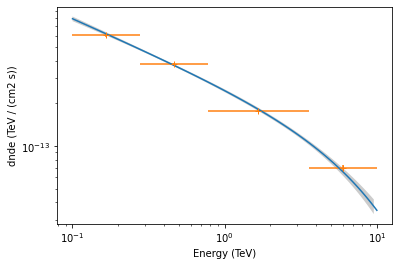

In [28]:
energy_range = [0.1, 10] * u.TeV
spec.plot(energy_range=energy_range, energy_power=2)
ax = spec.plot_error(energy_range=energy_range, energy_power=2)
flux_points.plot(ax=ax, energy_power=2)

In [29]:
def flux_plt(model, dataset):
    spec = model.spectral_model
    energy_edges = np.logspace(-1.0, 1.0, 5) * u.TeV
    fpe = FluxPointsEstimator(energy_edges=energy_edges)
    flux_points = fpe.run(datasets=[dataset])
    energy_range = [0.1, 10] * u.TeV
    spec.plot(energy_range=energy_range, energy_power=2)
    ax = spec.plot_error(energy_range=energy_range, energy_power=2)
    flux_points.plot(ax=ax, energy_power=2)
    plt.title("Livetime = "+str(dataset.gti.time_delta.to(u.hr)))#, fontsize='15')
    return